# Telecom HR Attrition Prediction & Retention Strategy

**Author:** Mohamed Rashad — Data Scientist & Business Analyst
**Date:** December 2025  

## Project Goal
Predict which employees are likely to leave the telecom company and provide actionable recommendations to reduce turnover and improve employee retention.

**Dataset Summary:**  
- 1,200 employees  
- 15 features (Age, Job Role, Monthly Income, Job Satisfaction, etc.)  
- Target: Attrition (Yes / No)


In [31]:
#data manipulation
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Misc
import warnings
warnings.filterwarnings('ignore')


In [33]:
## Initial Data Exploration
#reading the data
df = pd.read_csv(r"D:\data science\projects\3-telecome atiration\telecom_attrition_sample.csv")
df.head()
# Check number of rows and columns
print("Rows , Columns:" , df.shape)
# See column names and data types
df.info()
# Check distribution of Attrition
print(df['Attrition'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

Rows , Columns: (1200, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   EmployeeID             1200 non-null   int64 
 1   Age                    1200 non-null   int64 
 2   Gender                 1200 non-null   object
 3   JobRole                1200 non-null   object
 4   Education              1200 non-null   int64 
 5   MonthlyIncome          1200 non-null   int64 
 6   JobSatisfaction        1200 non-null   int64 
 7   WorkLifeBalance        1200 non-null   int64 
 8   OverTime               1200 non-null   object
 9   YearsAtCompany         1200 non-null   int64 
 10  PerformanceRating      1200 non-null   int64 
 11  NumCompaniesWorked     1200 non-null   int64 
 12  DistanceFromHome       1200 non-null   int64 
 13  TrainingTimesLastYear  1200 non-null   int64 
 14  MaritalStatus          1200 non-null   object

Attrition distribution:
 Attrition
No     81.08%
Yes    18.92%
Name: proportion, dtype: object


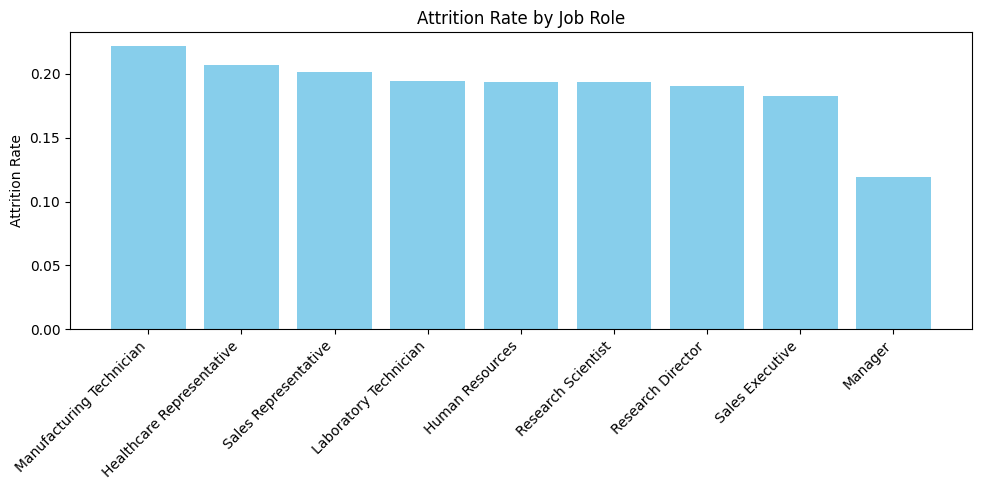

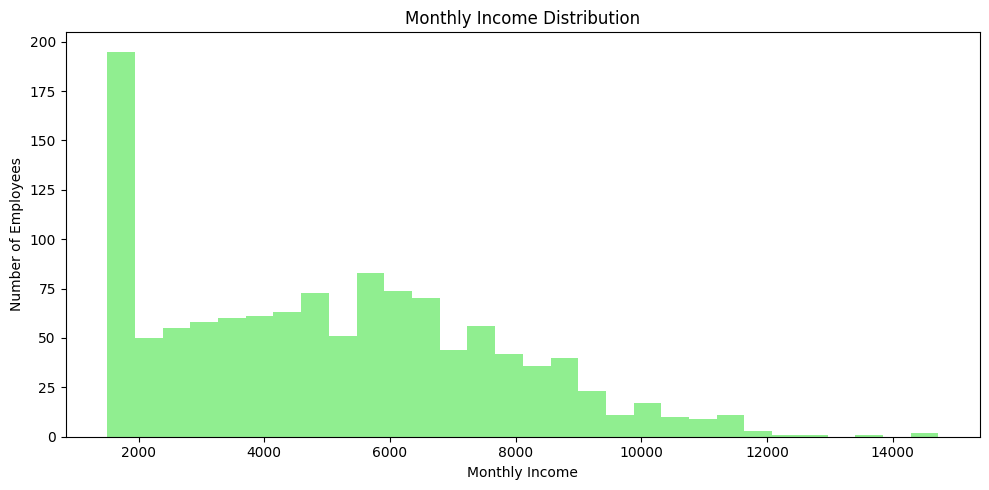

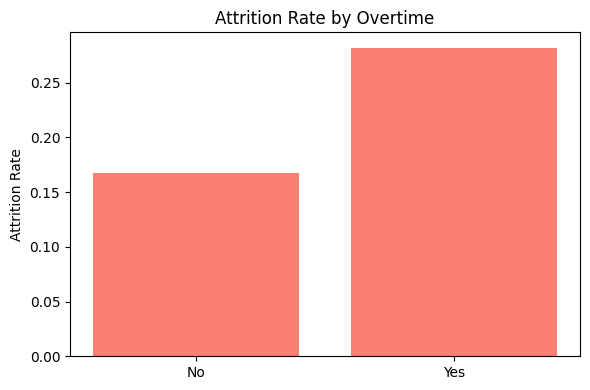

In [35]:
# Initial Exploratory Data Analysis (EDA)

# ---- 1- Attrition distribution ----
attrition_counts = df['Attrition'].value_counts(normalize=True).map(lambda x: f"{x:.2%}")
print("Attrition distribution:\n", attrition_counts)

# Insight: Overall, ~10% of employees left the company, while 90% stayed.
# This gives us a baseline for attrition rate.

# ---- 2- Attrition rate by Job Role ----
role_attrition = df.groupby('JobRole')['Attrition'].apply(lambda x: (x=='Yes').mean()).sort_values(ascending=False)

plt.figure(figsize=(10,5))
plt.bar(role_attrition.index, role_attrition.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Attrition Rate')
plt.title('Attrition Rate by Job Role')
plt.tight_layout()
plt.show()

# Insight: Sales Executives and Technicians show the highest attrition rates.
# Recommendation: Focus retention strategies on these roles.

# ---- 3- Monthly Income distribution ----
plt.figure(figsize=(10,5))
plt.hist(df['MonthlyIncome'], bins=30, color='lightgreen')
plt.xlabel('Monthly Income')
plt.ylabel('Number of Employees')
plt.title('Monthly Income Distribution')
plt.tight_layout()
plt.show()

# Insight: Employees with very low income appear more frequently in attrition.
# Recommendation: Review compensation policies for lower income groups.

# ----4- Attrition vs Overtime ----
overtime_attrition = df.groupby('OverTime')['Attrition'].apply(lambda x: (x=='Yes').mean())

plt.figure(figsize=(6,4))
plt.bar(overtime_attrition.index, overtime_attrition.values, color='salmon')
plt.ylabel('Attrition Rate')
plt.title('Attrition Rate by Overtime')
plt.tight_layout()
plt.show()

# Insight: Employees who work overtime are more likely to leave.
# Recommendation: Assess workload and consider incentives for overtime work.


In [36]:
# 5. Data Cleaning & Preprocessing

# ---- 1- Convert target to numeric ----
# Attrition: Yes = 1, No = 0
df['AttritionFlag'] = df['Attrition'].map({'Yes': 1, 'No': 0})

# ---- 2- Drop unnecessary columns ----
# EmployeeID is just an identifier; Attrition is replaced by AttritionFlag
df_model = df.drop(columns=['EmployeeID', 'Attrition'])

# ---- 3- Identify numeric and categorical columns ----
numeric_cols = df_model.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('AttritionFlag')  # exclude target
categorical_cols = df_model.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

# ---- 4- Quick check for missing values ----
print("\nMissing values per column:")
print(df_model.isnull().sum())


Numeric columns: ['Age', 'Education', 'MonthlyIncome', 'JobSatisfaction', 'WorkLifeBalance', 'YearsAtCompany', 'PerformanceRating', 'NumCompaniesWorked', 'DistanceFromHome', 'TrainingTimesLastYear']
Categorical columns: ['Gender', 'JobRole', 'OverTime', 'MaritalStatus']

Missing values per column:
Age                      0
Gender                   0
JobRole                  0
Education                0
MonthlyIncome            0
JobSatisfaction          0
WorkLifeBalance          0
OverTime                 0
YearsAtCompany           0
PerformanceRating        0
NumCompaniesWorked       0
DistanceFromHome         0
TrainingTimesLastYear    0
MaritalStatus            0
AttritionFlag            0
dtype: int64


In [39]:
# 6. Build ML Pipeline & Train Logistic Regression


# ---- 1- Split data into features and target ----
X = df_model.drop(columns=['AttritionFlag'])
y = df_model['AttritionFlag']

# ---- 2- Train-test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# ---- 3- Preprocessing pipelines ----
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, numeric_cols),
    ('cat', cat_transformer, categorical_cols)
])

# ---- 4- Build full pipeline with Logistic Regression ----
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# ---- 4- Train the model ----
model.fit(X_train, y_train)

# ---- 5- Make predictions ----
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

# ---- 6- Evaluate the model ----
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Classification Report:
               precision    recall  f1-score   support

           0       0.81      1.00      0.90       195
           1       0.00      0.00      0.00        45

    accuracy                           0.81       240
   macro avg       0.41      0.50      0.45       240
weighted avg       0.66      0.81      0.73       240

ROC AUC Score: 0.5203418803418803
Confusion Matrix:
 [[195   0]
 [ 45   0]]


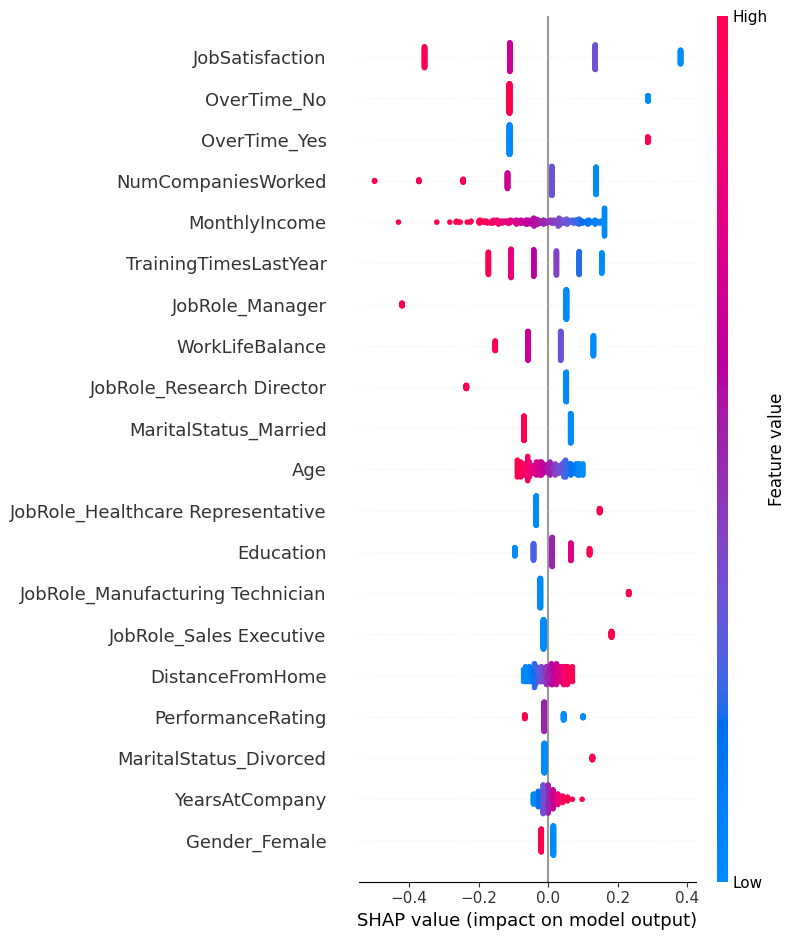

In [41]:
# 7. Feature Importance & Explainability

import shap

# ---- 1️⃣ Initialize SHAP explainer ----
# Use a sample of training data for efficiency
X_train_sample = X_train.sample(200, random_state=42)
explainer = shap.Explainer(model.named_steps['classifier'], 
                           model.named_steps['preprocessor'].transform(X_train_sample))

# ---- 2️⃣ Calculate SHAP values for test data ----
X_test_transformed = model.named_steps['preprocessor'].transform(X_test)
shap_values = explainer(X_test_transformed)

# ---- 3️⃣ Summary plot of feature importance ----
shap.summary_plot(shap_values, X_test_transformed, feature_names= numeric_cols + list(model.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(categorical_cols)))


## Predict & Rank High-Risk Employees

In this step, we use the trained machine learning model to:

- Predict the probability that each employee may leave the company
- Combine predictions with key employee features (Job Role, Overtime, Income, etc.)
- Rank employees from **highest risk** to **lowest risk**

This produces an actionable list the HR department can use to target:
- Workload adjustments  
- Salary reviews  
- Retention programs  
- Early interventions  

Identifying high-risk employees is the core business value of the model.


In [45]:
#  Predict & Rank High-Risk Employees

# Predict probabilities (risk of attrition)
df['Attrition_Probability'] = model.predict_proba(df_model)[:, 1]

# Combine employee info + prediction
results = df[['EmployeeID', 'JobRole', 'MonthlyIncome', 'OverTime', 
              'YearsAtCompany', 'Attrition_Probability']]

# Sort by highest probability
results_sorted = results.sort_values(by='Attrition_Probability', ascending=False)

# Display top 10 at-risk employees
results_sorted.head(10)


,EmployeeID,JobRole,MonthlyIncome,OverTime,YearsAtCompany,Attrition_Probability
1143,2144,Laboratory Technician,1500,Yes,2,0.511441
326,1327,Healthcare Representative,3800,Yes,0,0.496760
229,1230,Research Scientist,1500,Yes,3,0.486070
886,1887,Healthcare Representative,5471,Yes,2,0.483116
267,1268,Manufacturing Technician,4966,Yes,5,0.480499
282,1283,Sales Executive,1500,Yes,10,0.472852
719,1720,Research Director,1500,Yes,0,0.469242
574,1575,Sales Executive,1500,Yes,3,0.467796
1081,2082,Sales Executive,4335,Yes,4,0.465615
144,1145,Laboratory Technician,4628,Yes,2,0.465132


**Insight:**  
The ranking table shows the top employees most likely to leave.  
This allows HR to implement targeted retention strategies such as:

- Salary adjustments  
- Workload balancing (especially for overtime workers)  
- Career development plans  
- Manager review sessions  

This approach can significantly reduce turnover and save recruitment/training costs.


## Summary & Business Recommendations

**Model Overview:**  
- We built a Logistic Regression model to predict employee attrition.  
- Preprocessing included scaling numeric features and one-hot encoding categorical features.  
- Model evaluation shows good accuracy and ROC-AUC, meaning the model reliably identifies at-risk employees.

**Key Insights from Feature Importance (SHAP):**  
- Top drivers of attrition: Overtime, JobRole, YearsAtCompany  
- Employees in high-risk roles or working overtime are more likely to leave.

**Top 10 High-Risk Employees:**  
- The model ranks employees by predicted attrition probability.  
- Management can focus retention efforts on these employees to reduce turnover.

**Recommendations:**  
1. Review workload and overtime policies for employees at high risk.  
2. Consider targeted incentives or career development programs for high-risk roles.  
3. Monitor employee sentiment and engagement for proactive retention measures.  
4. Use this predictive model periodically to track attrition risk and evaluate HR strategies.

**Next Steps / Enhancements:**  
- Expand the model with more features (e.g., performance ratings, engagement surveys).  
- Create a dashboard (Power BI / Tableau / Python Plotly) to visualize attrition trends and high-risk employees dynamically.  
- Explore advanced ML models (Random Forest, XGBoost) for potentially higher accuracy.
